In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

In [8]:
Stock = 'MARA'

In [9]:
def day_trades(Stock, return_greater_than=0.01, days=2000, test_period=200, random_state=69, scoring_metric='precision'):
    # Calculate start and end dates
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)
    test_start_date = end_date - timedelta(days=test_period)

    # Store the stock symbol before it's overwritten
    stock_symbol = Stock

    def download_and_prepare_stock_data(symbol, start_date, end_date):
        data = yf.download(symbol, start=start_date, end=end_date)
        data = data.drop(columns=["Close", "High", "Low"])
        data["In_Day"] = (data['Adj Close'] - data['Open']) / data['Open']
        data['Volume'] = data['Volume'].pct_change()

        # Calculate daily return from previous day's adjusted close to today's adjusted close
        data[f'{symbol}_Daily_Return'] = data['Adj Close'].pct_change()

        return data.drop(columns=["Adj Close", "Open"])

    # Download and prepare main Stock data using helper function
    Stock = download_and_prepare_stock_data(stock_symbol, start_date, end_date)
    SPY = download_and_prepare_stock_data("SPY", start_date, end_date)  # Additional download for SPY to extract daily returns

    # Define the list of windows for moving averages
    windows = [2, 3, 4, 5, 10, 15, 20, 25, 30]

    # Collect the initial set of columns
    initial_columns = Stock.columns[:2]

    # Automatically detect all initial columns and calculate moving averages
    for column in initial_columns:
        for window in windows:
            Stock[f"{window}_day_MA_{column}"] = Stock[column].rolling(window=window).mean()

    # Calculate technical indicators directly in the day_trades function
    def relative_strength_idx(df, n=14):
        close = df["In_Day"]
        delta = close.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=n).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=n).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def compute_macd(df, n_fast=12, n_slow=26):
        ema_fast = df["In_Day"].ewm(span=n_fast, adjust=False).mean()
        ema_slow = df["In_Day"].ewm(span=n_slow, adjust=False).mean()
        return ema_fast - ema_slow

    Stock["RSI"] = relative_strength_idx(Stock)
    Stock["MACD"] = compute_macd(Stock)
    Stock["Volatility"] = Stock["In_Day"].rolling(window=10).std()
    Stock['SPY_Daily_Return'] = SPY['SPY_Daily_Return']
    Stock["SPY_In_Day"] = SPY["In_Day"]

    # Download and prepare data for other stocks during the same period using helper function
    symbols = ["AMZN", "BRK-B", "AAPL", "XOM", "SHW", "UPS", "AEP", "UNH", "PG", "BB", 'WMT', 'BB', 'PLUG', 'BB', 'HD',
               'SPWR', 'BYND', 'ROKU', 'SNDL', 'FCEL', 'STNE', 'BIG', 'JPM', 'NOK', 'V', 'NEE', 'PG', 'UNH']
    if stock_symbol in symbols:
        symbols.remove(stock_symbol)

    for symbol in symbols:
        other_data = download_and_prepare_stock_data(symbol, start_date, end_date)
        Stock[f"{symbol}_Returns"] = other_data["In_Day"]

    if not pd.api.types.is_datetime64_any_dtype(Stock.index):
        Stock.index = pd.to_datetime(Stock.index)

    df_clean = Stock[(Stock.index >= start_date) & (Stock.index <= end_date)]

    if df_clean.empty:
        print("No data available in the specified date range.")
        return None

    target = "In_Day"
    features = df_clean.columns.drop(target)
    X = df_clean[features]
    y = (df_clean[target] > return_greater_than).astype(int)

    X_train = X[X.index < test_start_date]
    X_test = X[X.index >= test_start_date]
    y_train = y[y.index < test_start_date]
    y_test = y[y.index >= test_start_date]

    if X_train.empty or X_test.empty:
        print("Training or test set is empty. Check the split date and the availability of data.")
        return None

    model = RandomForestClassifier(random_state=random_state)
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15],
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 5, 10],
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring_metric)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    df_clean["Buy"] = best_model.predict(X)

    # Predict for tomorrow by using the latest available data
    latest_data = X.iloc[-1:].copy()  # Get the latest data
    tomorrow_prediction = best_model.predict(latest_data)  # Make prediction for tomorrow
    latest_data_index = latest_data.index.max()  # Get the index of the latest data
    tomorrow_date = latest_data_index + pd.Timedelta(days=1)  # Calculate tomorrow's date
    df_clean.loc[tomorrow_date, "Buy"] = tomorrow_prediction[0]  # Apply tomorrow's prediction

    # Note: Since we don't have 'In_Day' for tomorrow, we cannot calculate 'Strategy Returns' for tomorrow yet
    df_clean["Strategy Returns"] = df_clean["Buy"].shift(1) * df_clean["In_Day"]
    df_clean["Buy Every Day Returns"] = df_clean["In_Day"]

    # Adding SPY daily returns and Stock daily returns to the output DataFrame
    df_clean["SPY_Daily_Return"] = SPY['SPY_Daily_Return']
    df_clean["SPY_In_Day"] = SPY["In_Day"]
    df_clean[f"{stock_symbol}_Daily_Return"] = Stock[f"{stock_symbol}_Daily_Return"]

    if tomorrow_prediction[0] == 1:
        print(f"Recommendation for tomorrow ({tomorrow_date.strftime('%Y-%m-%d')}): Buy")
    else:
        print(f"Recommendation for tomorrow ({tomorrow_date.strftime('%Y-%m-%d')}): Do not buy")

    # Extract returns information
    returns = df_clean.loc[X_test.index, ["Strategy Returns", "Buy Every Day Returns", "SPY_In_Day", "SPY_Daily_Return", f"{stock_symbol}_Daily_Return"]]
    print(tomorrow_date, tomorrow_prediction[0])

    return returns


In [10]:
def analyze_investment_strategy(returns, risk_free_rate=0):
    # Step 1: Generate the confusion matrix
    TP, FP, FN, TN = 0, 0, 0, 0
    for strategy, every in zip(returns["Strategy Returns"], returns["Buy Every Day Returns"]):
        if strategy > 0:
            TP += 1
        elif strategy < 0:
            FP += 1
        elif strategy <= 0 and every > 0:
            FN += 1
        elif strategy <= 0 and every <= 0:
            TN += 1

    confusion_matrix = {
        "True Positive (TP)": TP,
        "False Positive (FP)": FP,
        "False Negative (FN)": FN,
        "True Negative (TN)": TN,
    }
    print("Confusion Matrix:")
    for key, value in confusion_matrix.items():
        print(f"{key}: {value}")

    # Step 2: Calculate summary statistics
    mean_returns = returns.mean()
    stdev_returns = returns.std()
    sharpe_ratio = (mean_returns - risk_free_rate) / stdev_returns
    summary_df = pd.DataFrame({
        'Mean Returns': mean_returns,
        'Standard Deviation': stdev_returns,
        'Sharpe Ratio': sharpe_ratio
    })
    print("\nSummary Statistics:")
    print(summary_df)

    # Step 3: Plot returns
    strategy_col = 'Strategy Returns'
    stock_col = 'Buy Every Day Returns'
    spy_in_day_col = 'SPY_In_Day'
    spy_daily_col = "SPY_Daily_Return"
    stock_daily_col = returns.columns[-1]

    returns["Cumulative " + strategy_col] = (1 + returns[strategy_col]).cumprod()
    returns["Cumulative " + stock_col] = (1 + returns[stock_col]).cumprod()
    returns["Cumulative " + stock_daily_col] = (1 + returns[stock_daily_col]).cumprod()
    returns["Cumulative " + spy_daily_col] = (1 + returns[spy_daily_col]).cumprod()
    returns["Cumulative " + spy_in_day_col] = (1 + returns[spy_in_day_col]).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(returns.index, returns["Cumulative " + strategy_col], label='Cumulative Strategy Return', linestyle='-', linewidth=2, color='red')
    plt.plot(returns.index, returns["Cumulative " + stock_col], label='Cumulative Buy Every Day Return', linestyle='--', linewidth=2, color='blue')
    plt.plot(returns.index, returns["Cumulative " + stock_daily_col], label='Cumulative Stock Daily Return', linestyle='-.', linewidth=2, color='green')
    plt.plot(returns.index, returns["Cumulative " + spy_daily_col], label='Cumulative SPY Daily Return', linestyle=':', linewidth=2, color='purple')
    plt.plot(returns.index, returns["Cumulative " + spy_in_day_col], label='Cumulative SPY Buy Every Day Return', linestyle='-', linewidth=2, color='orange')

    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
returns = day_trades(Stock)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Recommendation for tomorrow (2024-05-15): Buy
2024-05-15 00:00:00 1


/var/folders/8_/kbj5l0wd3pdgsm_x7tplvrzc0000gn/T/ipykernel_59661/192432545.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Buy"] = best_model.predict(X)
/var/folders/8_/kbj5l0wd3pdgsm_x7tplvrzc0000gn/T/ipykernel_59661/192432545.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[tomorrow_date, "Buy"] = tomorrow_prediction[0]  # Apply tomorrow's prediction


Confusion Matrix:
True Positive (TP): 36
False Positive (FP): 24
False Negative (FN): 38
True Negative (TN): 38

Summary Statistics:
                       Mean Returns  Standard Deviation  Sharpe Ratio
Strategy Returns           0.007928            0.042397      0.186991
Buy Every Day Returns      0.005344            0.067305      0.079403
SPY_In_Day                -0.002350            0.005572     -0.421743
SPY_Daily_Return           0.001861            0.007101      0.262094
MARA_Daily_Return          0.008012            0.075082      0.106714


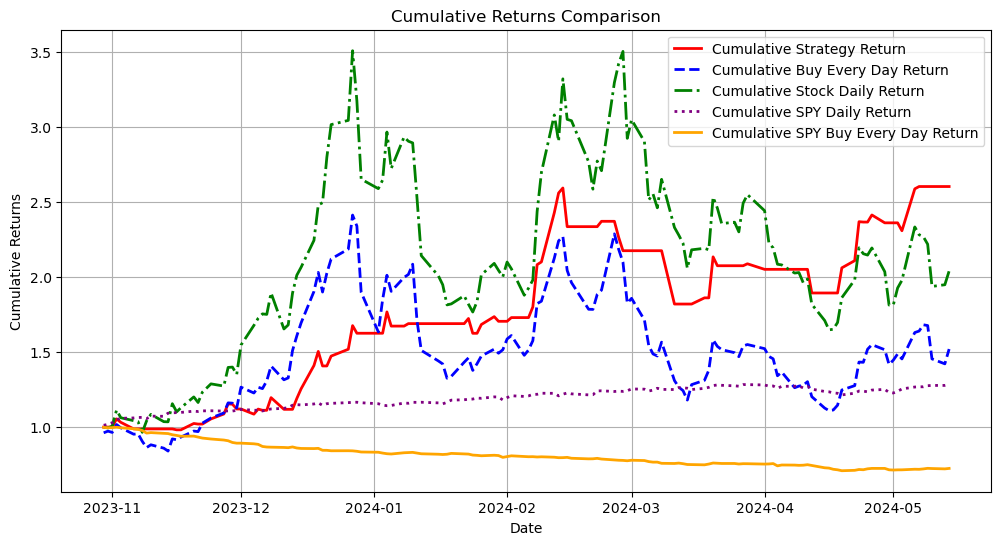

In [12]:
analyze_investment_strategy(returns)